### Can we classify a subject as having high vs low anxiety using their physiological signals? ###

In [2]:
# IMPORTING MODULES
import glob
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os
cvx_path = os.path.abspath(os.path.join('..', '..', 'cvxEDA', 'src'))
module_path = os.path.abspath(os.path.join('..', '..', 'src'))
sys.path.append(module_path)
import pandas as pd
import random
import scipy.signal as ss
import sys

import tools.data_reader_apd as dr
import tools.display_tools as dt
import tools.preprocessing as preprocessing
import train

from scipy.fft import fft, fftfreq, fftshift
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
from sklearn.preprocessing import normalize

import cvxopt.solvers
cvxopt.solvers.options['show_progress'] = False

import warnings
warnings.filterwarnings(
    "ignore", 
    category=RuntimeWarning
)

metrics = [
    "bpm", "rmssd", "hf_rr", "lf_rr", "ibi", "sdnn",
    "mean_SCL", "SCR_rate",
    "breathingrate",
    # "mean_ankle_activity_l", "mean_ankle_activity_r",
    # "mean_wrist_activity_l", "mean_wrist_activity_r",
    # "peak_ankle_acc_l", "peak_ankle_acc_r",
    # "peak_wrist_acc_l", "peak_wrist_acc_r",
    # "mean_posture"
]

test_phases = [
    [
        dr.Phases.BASE_REST,
        dr.Phases.BUG_RELAX, dr.Phases.BUG_ANTICIPATE, dr.Phases.BUG_EXPOSURE, dr.Phases.BUG_BREAK,
        dr.Phases.SPEECH_RELAX, dr.Phases.SPEECH_ANTICIPATE, dr.Phases.SPEECH_EXPOSURE, dr.Phases.SPEECH_BREAK
    ],
    [dr.Phases.BASE_REST, dr.Phases.BUG_RELAX, dr.Phases.SPEECH_RELAX],
    [
        dr.Phases.BASE_REST, dr.Phases.BUG_RELAX, dr.Phases.SPEECH_RELAX,
        dr.Phases.BUG_ANTICIPATE, dr.Phases.SPEECH_ANTICIPATE
    ],
    [dr.Phases.BUG_EXPOSURE, dr.Phases.SPEECH_EXPOSURE],
    [dr.Phases.BUG_REFLECT, dr.Phases.SPEECH_REFLECT]
]

test_weights = [
    None, None, None, None, None, None, None,
    
]

ModuleNotFoundError: No module named 'matplotlib'

In [14]:
# Helper functions for voting ensembles

def majority_vote(ensemble_preds):
    ensemble_preds = np.vstack(ensemble_preds).mean(axis=0)
    # Majority voting
    ensemble_preds[ensemble_preds < 0.5] = 0
    ensemble_preds[ensemble_preds > 0.5] = 1
    ensemble_preds = ensemble_preds.astype(int)
    return ensemble_preds


def weighted_vote(ensemble_preds, weights):
    ensemble_preds = np.multiply(ensemble_preds, weights)
    ensemble_preds = np.vstack(ensemble_preds).mean(axis=0)
    ensemble_preds[ensemble_preds < 0.5] = 0
    ensemble_preds[ensemble_preds > 0.5] = 1
    ensemble_preds = ensemble_preds.astype(int)
    return ensemble_preds


# Helper function for feature normalization
def normalize(input):
    pass

In [23]:
import random

NUM_SUBJECTS = 52

def train_test_split_ensemble(x, split_by="phase", metrics=None, test_size=0.1, split_by_subject=True):
    """
    Data separated by metrics and phases. 
    datasests[i][0] == x_train
    datasests[i][1] == y_train
    datasests[i][2] == x_test
    datasests[i][3] == y_test
    """
    metrics = x.columns[3:]
    datasets = []
    subjects = list(x.loc[:, "subject"].unique())
    if split_by_subject == True:
        test_subjects = random.sample(subjects, int(NUM_SUBJECTS*test_size))
    else:
        test_subjects = random.sample(x.shape[0], int(x.shape[0]*test_size))
    # print(f"test subjects: {test_subjects}")
    if split_by == "phase":
        phases = pd.unique(x.loc[:, "phaseId"])
        x_split = []
        y_split = []
        for phase in phases:
            temp_x = x.loc[x["phaseId"] == phase].reset_index(drop=True)
            temp_y = x.loc[x["phaseId"] == phase].loc[:, ["subject", "anxietyGroup"]].reset_index(drop=True)
            temp_x = temp_x.drop("anxietyGroup", axis=1)
            x_split.append(temp_x)
            y_split.append(temp_y)
        # x_split = pd.concat(x_split, axis=0, ignore_index=True)
        # y_split = pd.concat(y_split, axis=0, ignore_index=True)

    elif split_by == "metric":
        if metrics is None:
            raise ValueError("Metric list must be provided when splitting by metrics.")
        x_split = []
        y_split = []
        for metric in metrics:
            temp_x = x.loc[:, ["subject", "phaseId", f"{metric}"]].reset_index(drop=True)
            temp_y = x.loc[:, ["subject", "anxietyGroup"]].reset_index(drop=True)
            x_split.append(temp_x)
            y_split.append(temp_y)
        # x_split = pd.concat(x_split, axis=0, ignore_index=True)
        # y_split = pd.concat(y_split, axis=0, ignore_index=True)
    if split_by_subject == True:
        for i in range(len(x_split)):
            x_train = x_split[i].loc[~x_split[i]["subject"].isin(test_subjects)]
            y_train = y_split[i].loc[~y_split[i]["subject"].isin(test_subjects)]
            x_test = x_split[i].loc[x_split[i]["subject"].isin(test_subjects)]
            y_test = y_split[i].loc[y_split[i]["subject"].isin(test_subjects)]
    else:
        for i in range(len(x_split)):
            x_train = x_split[i].iloc[test_subjects, :]
            y_train = y_split[i].iloc[test_subjects, :]
            x_test = x_split[i].iloc[test_subjects, :]
            y_test = y_split[i].iloc[test_subjects, :]
            datasets.append([x_train, y_train, x_test, y_test])
    return datasets


def train_test_split_combined(x, split_by="phase", metrics=None, test_size=0.1, split_by_subject=True):
    """
    If split_by == "phase", len(datasets) == # of phases. All metrics combined for one phase.
    If split_by == "metric", len(datasets) == len(metrics). All phases combined for one metric.
    datasests[i][0] == x_train
    datasests[i][1] == y_train
    datasests[i][2] == x_test
    datasests[i][3] == y_test
    """
    metrics = x.columns[3:]
    datasets = []
    subjects = list(x.loc[:, "subject"].unique())
    if split_by_subject == True:
        test_subjects = random.sample(subjects, int(NUM_SUBJECTS*test_size))
    else:
        test_subjects = random.sample(x.shape[0], int(x.shape[0]*test_size))

    x = x.sort_values(by=["subject", "phaseId"])
    
    if split_by == "phase":
        phases = pd.unique(x.loc[:, "phaseId"])
        phase_dfs = {p: [] for p in phases}
        for s in subjects:
            s_df = x.loc[x["subject"] == s] 
            for i in range(s_df.shape[0]):
                phase_dfs[list(phase_dfs.keys())[i]].append(s_df.iloc[[i], :].reset_index(drop=True))
        for key in list(phase_dfs.keys()):
            temp_x = pd.concat(phase_dfs[key], axis=0)
            temp_y = temp_x.loc[:, ["subject", "anxietyGroup"]].reset_index(drop=True)
            temp_x = temp_x.drop(["phaseId", "anxietyGroup", "label"], axis=1)
            
            if split_by_subject == True:
                for i in range(len(x_split)):
                    x_train = x_split[i].loc[~x_split[i]["subject"].isin(test_subjects)]
                    y_train = y_split[i].loc[~y_split[i]["subject"].isin(test_subjects)]
                    x_test = x_split[i].loc[x_split[i]["subject"].isin(test_subjects)]
                    y_test = y_split[i].loc[y_split[i]["subject"].isin(test_subjects)]
            else:
                for i in range(len(x_split)):
                    x_train = x_split[i].iloc[test_subjects, :]
                    y_train = y_split[i].iloc[test_subjects, :]
                    x_test = x_split[i].iloc[test_subjects, :]
                    y_test = y_split[i].iloc[test_subjects, :]

            datasets.append([x_train, y_train, x_test, y_test])
            
        
    elif split_by == "metric":
        if metrics is None:
            raise ValueError("Metric list must be provided when splitting by metrics.")
        metric_dfs = {}
        phases = pd.unique(x.loc[:, "phaseId"])
        phase_dfs = {p: [] for p in phases}
        for s in subjects:
            s_df = x.loc[x["subject"] == s] 
            for i in range(s_df.shape[0]):
                phase_dfs[list(phase_dfs.keys())[i]].append(s_df.iloc[[i], :].reset_index(drop=True))
        for key in list(phase_dfs.keys()):
            phase_dfs[key] = pd.concat(phase_dfs[key], axis=0)
        subjects = list(phase_dfs.values())[0].loc[:, ["subject"]]
        temp_y = list(phase_dfs.values())[0].loc[:, ["subject", "anxietyGroup"]]
        for metric in metrics:
            df_list = [subjects] + [df.loc[:, [metric]] for df in phase_dfs.values()]
            temp_x = pd.concat(df_list, axis=1)
            metric_dfs[metric] = [temp_x, temp_y]
        
        for key in list(metric_dfs.keys()):
            temp_x = metric_dfs[key][0]
            temp_y = metric_dfs[key][1]
            
            if split_by_subject == True:
                for i in range(len(x_split)):
                    x_train = x_split[i].loc[~x_split[i]["subject"].isin(test_subjects)]
                    y_train = y_split[i].loc[~y_split[i]["subject"].isin(test_subjects)]
                    x_test = x_split[i].loc[x_split[i]["subject"].isin(test_subjects)]
                    y_test = y_split[i].loc[y_split[i]["subject"].isin(test_subjects)]
            else:
                for i in range(len(x_split)):
                    x_train = x_split[i].iloc[test_subjects, :]
                    y_train = y_split[i].iloc[test_subjects, :]
                    x_test = x_split[i].iloc[test_subjects, :]
                    y_test = y_split[i].iloc[test_subjects, :]
                    
            datasets.append([x_train, y_train, x_test, y_test])

    return datasets

def train_ensemble(clfs, datasets, weights=None, eval_metrics="all"):
    all_preds = []
    actual = []

    for i in range(len(clfs)):
        x_train = datasets[i][0] 
        y_train = datasets[i][1].iloc[:, 1]
        x_test = datasets[i][2]
        y_test = datasets[i][3].iloc[:, 1]
        
        # x_train = np.asarray(x_train)
        # y_train = np.asarray(y_train)
        # x_test = np.asarray(x_test)
        # y_test = np.asarray(y_test)
        # print(f"x_train: {x_train.shape}")
        # print(f"y_train: {y_train.shape}")
        # print(f"x_test: {x_test.shape}")
        # print(f"y_test: {y_test.shape}")

        clfs[i].fit(x_train, y_train)
        preds = clfs[i].predict(x_test)

        all_preds.append(preds)
        actual.append(y_test)
    actual = actual[0]
    if weights is None:
        preds = majority_vote(all_preds)
    else:
        preds = weighted_vote(all_preds, weights)

    # print(confusion_matrix(actual, preds))
    # print(classification_report(actual, preds))

    if eval_metrics == "acc":
        acc = accuracy_score(actual, preds)
    elif eval_metrics == "all": 
        acc = [
            accuracy_score(actual, preds),
            precision_score(actual, preds, zero_division=0),
            recall_score(actual, preds, zero_division=0)
        ]
    
    # actual = [str(i) for i in actual]
    # preds = list(preds)
    # preds = [str(i) for i in preds]
    # print((' ').join(actual))
    # print((' ').join(preds))

    return acc

In [75]:
# SVM ENSEMBLE
importlib.reload(train)
importlib.reload(preprocessing)
importlib.reload(dr)
importlib.reload(dt)

import csv
import random

from sklearn.ensemble import VotingClassifier

num_rounds = 10
label_type = "Trait"
test_size = 0.15

accs_svm_metrics = []
accs_svm_phases = []

# print(f"Accuracy over {num_rounds} rounds " + "-"*30)
for phases in test_phases:
    x, y = train.Train_APD.get_apd_data_ranking(metrics, phases, anxiety_label_type=label_type)
    x = pd.concat([x, y.iloc[:, 1:]], axis=1)
    x = x[x["subject"] != 84.0]
    datasets = train_test_split_ensemble(x, split_by="metric", metrics=metrics, test_size=test_size)
    clfs = [svm.SVC(C=10, gamma=1) for _ in range(len(datasets))]

    acc = []
    for _ in range(num_rounds):
        acc.append(train_ensemble(clfs, datasets))
    # print(f"{(' ').join(phases)}:\n{np.mean(acc)}")
    accs_svm_metrics.append(np.mean(acc, axis=0))

    x, y = train.Train_APD.get_apd_data_ranking(metrics, phases, anxiety_label_type=label_type)
    x = pd.concat([x, y.iloc[:, 1:]], axis=1)
    x = x[x["subject"] != 84.0]
    datasets = train_test_split_ensemble(x, split_by="phase", metrics=metrics, test_size=test_size)
    clfs = [svm.SVC(C=10, gamma=1) for _ in range(len(datasets))]

    acc = []
    for _ in range(num_rounds):
        acc.append(train_ensemble(clfs, datasets))
    # print(f"{(' ').join(phases)}:\n{np.mean(acc)}")
    accs_svm_phases.append(np.mean(acc, axis=0))


# ------------------------------------------------------------------------
# SVM PHASES COMBINED
accs_svm_metrics_combined = []
accs_svm_phases_combined = []

# print(f"Accuracy over {num_rounds} rounds " + "-"*30)
for phases in test_phases:
    x, y = train.Train_APD.get_apd_data_ranking(metrics, phases, anxiety_label_type=label_type)
    x = pd.concat([x, y.iloc[:, 1:]], axis=1)
    x = x[x["subject"] != 84.0]
    datasets = train_test_split_combined(x, split_by="metric", metrics=metrics, test_size=test_size)
    clfs = [svm.SVC(C=10, gamma=1) for _ in range(len(datasets))]

    acc = []
    for _ in range(num_rounds):
        acc.append(train_ensemble(clfs, datasets))
    # print(f"{(' ').join(phases)}:\n{np.mean(acc)}")
    accs_svm_metrics_combined.append(np.mean(acc, axis=0))

    x, y = train.Train_APD.get_apd_data_ranking(metrics, phases, anxiety_label_type=label_type)
    x = pd.concat([x, y.iloc[:, 1:]], axis=1)
    x = x[x["subject"] != 84.0]
    datasets = train_test_split_combined(x, split_by="phase", metrics=metrics, test_size=test_size)
    clfs = [svm.SVC(C=10, gamma=1) for _ in range(len(datasets))]

    acc = []
    for _ in range(num_rounds):
        acc.append(train_ensemble(clfs, datasets))
    # print(f"{(' ').join(phases)}:\n{np.mean(acc)}")
    accs_svm_phases_combined.append(np.mean(acc, axis=0))



In [80]:
# KNN ENSEMBLE
importlib.reload(train)
importlib.reload(preprocessing)
importlib.reload(dr)
importlib.reload(dt)

import csv
import random

from sklearn.ensemble import VotingClassifier

num_rounds = 10
label_type = "Trait"
test_size = 0.15

accs_knn_metrics = []
accs_knn_phases = []

# print(f"Accuracy over {num_rounds} rounds " + "-"*30)
for phases in test_phases:
    x, y = train.Train_APD.get_apd_data_ranking(metrics, phases, anxiety_label_type=label_type)
    x = pd.concat([x, y.iloc[:, 1:]], axis=1)
    x = x[x["subject"] != 84.0]
    datasets = train_test_split_ensemble(x, split_by="metric", metrics=metrics, test_size=test_size)
    clfs = [KNeighborsClassifier(n_neighbors=7) for _ in range(len(datasets))]

    acc = []
    for _ in range(num_rounds):
        acc.append(train_ensemble(clfs, datasets))
    acc = np.asarray(acc)
    # print(f"{(' ').join(phases)}:\n{np.mean(acc)}")
    accs_knn_metrics.append(np.mean(acc, axis=0))

    x, y = train.Train_APD.get_apd_data_ranking(metrics, phases, anxiety_label_type=label_type)
    x = pd.concat([x, y.iloc[:, 1:]], axis=1)
    x = x[x["subject"] != 84.0]
    datasets = train_test_split_ensemble(x, split_by="phase", metrics=metrics, test_size=test_size)
    clfs = [KNeighborsClassifier(n_neighbors=7) for _ in range(len(datasets))]

    acc = []
    for _ in range(num_rounds):
        acc.append(train_ensemble(clfs, datasets))
    acc = np.asarray(acc)
    # print(f"{(' ').join(phases)}:\n{np.mean(acc)}")
    accs_knn_phases.append(np.mean(acc, axis=0))


# ------------------------------------------------------------------------
# KNN PHASES COMBINED
accs_knn_metrics_combined = []
accs_knn_phases_combined = []

# print(f"Accuracy over {num_rounds} rounds " + "-"*30)
for phases in test_phases:
    x, y = train.Train_APD.get_apd_data_ranking(metrics, phases, anxiety_label_type=label_type)
    x = pd.concat([x, y.iloc[:, 1:]], axis=1)
    x = x[x["subject"] != 84.0]
    datasets = train_test_split_combined(x, split_by="metric", metrics=metrics, test_size=test_size)
    clfs = [KNeighborsClassifier(n_neighbors=7) for _ in range(len(datasets))]

    acc = []
    for _ in range(num_rounds):
        acc.append(train_ensemble(clfs, datasets))
    acc = np.asarray(acc)
    accs_knn_metrics_combined.append(np.mean(acc, axis=0))

    x, y = train.Train_APD.get_apd_data_ranking(metrics, phases, anxiety_label_type=label_type)
    x = pd.concat([x, y.iloc[:, 1:]], axis=1)
    x = x[x["subject"] != 84.0]
    datasets = train_test_split_combined(x, split_by="phase", metrics=metrics, test_size=test_size)
    clfs = [KNeighborsClassifier(n_neighbors=7) for _ in range(len(datasets))]

    acc = []
    for _ in range(num_rounds):
        acc.append(train_ensemble(clfs, datasets))
    acc = np.asarray(acc)
    accs_knn_phases_combined.append(np.mean(acc, axis=0))


In [24]:
from sklearn.tree import DecisionTreeClassifier
# DT ENSEMBLE -- CURRENTLY DOES NOT USE LABELS AS A METRIC
importlib.reload(train)
importlib.reload(preprocessing)
importlib.reload(dr)
importlib.reload(dt)

import csv
import random

from sklearn.ensemble import VotingClassifier

num_rounds = 10
label_type = "Trait"
test_size = 0.15

accs_dt_metrics = []
accs_dt_phases = []

# print(f"Accuracy over {num_rounds} rounds " + "-"*30)
for phases in test_phases:
    x, y = train.Train_APD.get_apd_data_ranking(metrics, phases, anxiety_label_type=label_type)
    x = pd.concat([x, y.iloc[:, 1:]], axis=1)
    x = x[x["subject"] != 84.0]
    datasets = train_test_split_ensemble(x, split_by="metric", metrics=metrics, test_size=test_size)
    clfs = [DecisionTreeClassifier() for _ in range(len(datasets))]

    acc = []
    for _ in range(num_rounds):
        acc.append(train_ensemble(clfs, datasets))
    acc = np.asarray(acc)
    # print(f"{(' ').join(phases)}:\n{np.mean(acc)}")
    accs_dt_metrics.append(np.mean(acc, axis=0))

    x, y = train.Train_APD.get_apd_data_ranking(metrics, phases, anxiety_label_type=label_type)
    x = pd.concat([x, y.iloc[:, 1:]], axis=1)
    x = x[x["subject"] != 84.0]
    datasets = train_test_split_ensemble(x, split_by="phase", metrics=metrics, test_size=test_size)
    clfs = [DecisionTreeClassifier() for _ in range(len(datasets))]

    acc = []
    for _ in range(num_rounds):
        acc.append(train_ensemble(clfs, datasets))
    acc = np.asarray(acc)
    # print(f"{(' ').join(phases)}:\n{np.mean(acc)}")
    accs_dt_phases.append(np.mean(acc, axis=0))


# ------------------------------------------------------------------------
# DT PHASES COMBINED
accs_dt_metrics_combined = []
accs_dt_phases_combined = []

# print(f"Accuracy over {num_rounds} rounds " + "-"*30)
for phases in test_phases:
    x, y = train.Train_APD.get_apd_data_ranking(metrics, phases, anxiety_label_type=label_type)
    x = pd.concat([x, y.iloc[:, 1:]], axis=1)
    x = x[x["subject"] != 84.0]
    datasets = train_test_split_combined(x, split_by="metric", metrics=metrics, test_size=test_size)
    clfs = [DecisionTreeClassifier() for _ in range(len(datasets))]

    acc = []
    for _ in range(num_rounds):
        acc.append(train_ensemble(clfs, datasets))
    acc = np.asarray(acc)
    accs_dt_metrics_combined.append(np.mean(acc, axis=0))

    x, y = train.Train_APD.get_apd_data_ranking(metrics, phases, anxiety_label_type=label_type)
    x = pd.concat([x, y.iloc[:, 1:]], axis=1)
    x = x[x["subject"] != 84.0]
    datasets = train_test_split_combined(x, split_by="phase", metrics=metrics, test_size=test_size)
    clfs = [DecisionTreeClassifier() for _ in range(len(datasets))]

    acc = []
    for _ in range(num_rounds):
        acc.append(train_ensemble(clfs, datasets))
    acc = np.asarray(acc)
    accs_dt_phases_combined.append(np.mean(acc, axis=0))


IndexError: list index out of range

In [81]:
# KNN
# Outputs are {phase list}: {accuracy}, {precision}, {recall} 
thresh = 0.7

highest_acc = []
med_acc = np.median([res[1] for res in accs_knn_metrics])
print("KNN ACCURACY METRIC SPLIT" + "-"*30)
acc_str = ""
for i in range(len(accs_knn_metrics)):
    acc = accs_knn_metrics[i][0]
    acc_str += str(acc) + " "
    if i % 4 == 0 and i != 0:
        acc_str += "\n"
    if acc > thresh:
        highest_acc.append([test_phases[i], accs_knn_metrics[i]])
# print(acc_str)
highest_acc.sort(key=lambda x: x[1][0], reverse=True)
print("HIGHEST ACCURACY PHASES " + "-"*30)
for res in highest_acc:
    print(f"{res[0]}: {res[1][0]}, {res[1][1]}, {res[1][2]}")
print("")

highest_acc = []
med_acc = np.median([res[1] for res in accs_knn_phases])
print("KNN ACCURACY PHASE SPLIT" + "-"*30)
acc_str = ""
for i in range(len(accs_knn_phases)):
    acc = accs_knn_phases[i][0]
    acc_str += str(acc) + " "
    if i % 4 == 0 and i != 0:
        acc_str += "\n"
    if acc > thresh:
        highest_acc.append([test_phases[i], accs_knn_phases[i]])
# print(acc_str)
highest_acc.sort(key=lambda x: x[1][0], reverse=True)
print("HIGHEST ACCURACY PHASES " + "-"*30)
for res in highest_acc:
    print(f"{res[0]}: {res[1][0]}, {res[1][1]}, {res[1][2]}")
print("")

highest_acc = []
med_acc = np.median([res[1] for res in accs_knn_metrics_combined])
print("KNN ACCURACY METRIC SPLIT COMBINED" + "-"*30)
acc_str = ""
for i in range(len(accs_knn_metrics_combined)):
    acc = accs_knn_metrics_combined[i][0]
    acc_str += str(acc) + " "
    if i % 4 == 0 and i != 0:
        acc_str += "\n"
    if acc > thresh:
        highest_acc.append([test_phases[i], accs_knn_metrics_combined[i]])
# print(acc_str)
highest_acc.sort(key=lambda x: x[1][0], reverse=True)
print("HIGHEST ACCURACY PHASES " + "-"*30)
for res in highest_acc:
    print(f"{res[0]}: {res[1][0]}, {res[1][1]}, {res[1][2]}")
print("")

highest_acc = []
med_acc = np.median([res[1] for res in accs_knn_phases_combined])
print("KNN ACCURACY PHASE SPLIT COMBINED" + "-"*30)
acc_str = ""
for i in range(len(accs_knn_phases_combined)):
    acc = accs_knn_phases_combined[i][0]
    acc_str += str(acc) + " "
    if i % 4 == 0 and i != 0:
        acc_str += "\n"
    if acc > thresh:
        highest_acc.append([test_phases[i], accs_knn_phases_combined[i]])
# print(acc_str)
highest_acc.sort(key=lambda x: x[1][0], reverse=True)
print("HIGHEST ACCURACY PHASES " + "-"*30)
for res in highest_acc:
    print(f"{res[0]}: {res[1][0]}, {res[1][1]}, {res[1][2]}")
print("")


KNN ACCURACY METRIC SPLIT------------------------------
HIGHEST ACCURACY PHASES ------------------------------
['Baseline_Rest', 'BugBox_Relax', 'Speech_Relax']: 0.857142857142857, 0.75, 1.0
['Baseline_Rest', 'BugBox_Relax', 'BugBox_Anticipate', 'BugBox_Exposure', 'BugBox_Break', 'Speech_Relax', 'Speech_Anticipate', 'Speech_Exposure', 'Speech_Break']: 0.7142857142857143, 1.0, 0.5
['BugBox_Exposure', 'Speech_Exposure']: 0.7142857142857143, 1.0, 0.5

KNN ACCURACY PHASE SPLIT------------------------------
HIGHEST ACCURACY PHASES ------------------------------
['Baseline_Rest', 'BugBox_Relax', 'BugBox_Anticipate', 'BugBox_Exposure', 'BugBox_Break', 'Speech_Relax', 'Speech_Anticipate', 'Speech_Exposure', 'Speech_Break']: 0.7142857142857143, 0.75, 0.75
['Baseline_Rest', 'BugBox_Relax', 'Speech_Relax', 'BugBox_Anticipate', 'Speech_Anticipate']: 0.7142857142857143, 0.75, 0.75

KNN ACCURACY METRIC SPLIT COMBINED------------------------------
HIGHEST ACCURACY PHASES -----------------------------

In [22]:
# DT
# Outputs are {phase list}: {accuracy}, {precision}, {recall} 
thresh = 0.7

highest_acc = []
med_acc = np.median([res[1] for res in accs_dt_metrics])
print("DT ACCURACY METRIC SPLIT" + "-"*30)
acc_str = ""
for i in range(len(accs_dt_metrics)):
    acc = accs_dt_metrics[i][0]
    acc_str += str(acc) + " "
    if i % 4 == 0 and i != 0:
        acc_str += "\n"
    if acc > thresh:
        highest_acc.append([test_phases[i], accs_dt_metrics[i]])
# print(acc_str)
highest_acc.sort(key=lambda x: x[1][0], reverse=True)
print("HIGHEST ACCURACY PHASES " + "-"*30)
for res in highest_acc:
    print(f"{res[0]}: {res[1][0]}, {res[1][1]}, {res[1][2]}")
print("")

highest_acc = []
med_acc = np.median([res[1] for res in accs_dt_phases])
print("DT ACCURACY PHASE SPLIT" + "-"*30)
acc_str = ""
for i in range(len(accs_dt_phases)):
    acc = accs_dt_phases[i][0]
    acc_str += str(acc) + " "
    if i % 4 == 0 and i != 0:
        acc_str += "\n"
    if acc > thresh:
        highest_acc.append([test_phases[i], accs_dt_phases[i]])
# print(acc_str)
highest_acc.sort(key=lambda x: x[1][0], reverse=True)
print("HIGHEST ACCURACY PHASES " + "-"*30)
for res in highest_acc:
    print(f"{res[0]}: {res[1][0]}, {res[1][1]}, {res[1][2]}")
print("")

highest_acc = []
med_acc = np.median([res[1] for res in accs_dt_metrics_combined])
print("DT ACCURACY METRIC SPLIT COMBINED" + "-"*30)
acc_str = ""
for i in range(len(accs_dt_metrics_combined)):
    acc = accs_dt_metrics_combined[i][0]
    acc_str += str(acc) + " "
    if i % 4 == 0 and i != 0:
        acc_str += "\n"
    if acc > thresh:
        highest_acc.append([test_phases[i], accs_dt_metrics_combined[i]])
# print(acc_str)
highest_acc.sort(key=lambda x: x[1][0], reverse=True)
print("HIGHEST ACCURACY PHASES " + "-"*30)
for res in highest_acc:
    print(f"{res[0]}: {res[1][0]}, {res[1][1]}, {res[1][2]}")
print("")

highest_acc = []
med_acc = np.median([res[1] for res in accs_dt_phases_combined])
print("DT ACCURACY PHASE SPLIT COMBINED" + "-"*30)
acc_str = ""
for i in range(len(accs_dt_phases_combined)):
    acc = accs_dt_phases_combined[i][0]
    acc_str += str(acc) + " "
    if i % 4 == 0 and i != 0:
        acc_str += "\n"
    if acc > thresh:
        highest_acc.append([test_phases[i], accs_dt_phases_combined[i]])
# print(acc_str)
highest_acc.sort(key=lambda x: x[1][0], reverse=True)
print("HIGHEST ACCURACY PHASES " + "-"*30)
for res in highest_acc:
    print(f"{res[0]}: {res[1][0]}, {res[1][1]}, {res[1][2]}")
print("")

DT ACCURACY METRIC SPLIT------------------------------
HIGHEST ACCURACY PHASES ------------------------------
['BugBox_Reflect', 'Speech_Reflect']: 0.857142857142857, 1.0, 0.5
['Baseline_Rest', 'BugBox_Relax', 'BugBox_Anticipate', 'BugBox_Exposure', 'BugBox_Break', 'Speech_Relax', 'Speech_Anticipate', 'Speech_Exposure', 'Speech_Break']: 0.7142857142857143, 0.6666666666666667, 0.6666666666666667

DT ACCURACY PHASE SPLIT------------------------------
HIGHEST ACCURACY PHASES ------------------------------
['BugBox_Reflect', 'Speech_Reflect']: 0.9428571428571428, 1.0, 0.9
['BugBox_Exposure', 'Speech_Exposure']: 0.857142857142857, 0.6666666666666667, 1.0

DT ACCURACY METRIC SPLIT COMBINED------------------------------
HIGHEST ACCURACY PHASES ------------------------------
['Baseline_Rest', 'BugBox_Relax', 'Speech_Relax']: 0.9428571428571428, 0.8666666666666666, 1.0
['Baseline_Rest', 'BugBox_Relax', 'BugBox_Anticipate', 'BugBox_Exposure', 'BugBox_Break', 'Speech_Relax', 'Speech_Anticipate', 

In [242]:
# Helper method for plotting extracted metrics

def plot_metrics(metrics, phases):
    metrics_folder = os.path.join(dr.Paths.DATA_DIR, "metrics")
    datasets = []
    for metric in metrics:
        ha = []
        la = []
        for phase in phases:
            file = os.path.join(metrics_folder, f"{metric}_{phase}_ha.csv")
            arr = pd.read_csv(file, header=None, index_col=[0]).to_numpy()
            arr = arr[1:, 1:]
            col_mean = np.nanmean(arr, axis=1)
            idx = np.where(np.isnan(arr))
            arr[idx] = np.take(col_mean, idx[0])
            arr = np.nan_to_num(arr)
            arr = normalize(arr)

            ha.append(arr)

            file = os.path.join(metrics_folder, f"{metric}_{phase}_la.csv")
            arr = pd.read_csv(file, header=None, index_col=[0]).to_numpy()
            arr = arr[1:, 1:]
            col_mean = np.nanmean(arr, axis=1)
            idx = np.where(np.isnan(arr))
            arr[idx] = np.take(col_mean, idx[0])
            arr = np.nan_to_num(arr)
            arr = normalize(arr)

            la.append(arr)

        ha_arr = np.hstack(ha)
        la_arr = np.hstack(la)
        # ha_arr = normalize(ha_arr)
        # la_arr = normalize(la_arr)

        max_len = np.max([ha_arr.shape[1], la_arr.shape[1]])
        ha_arr = np.pad(ha_arr, ((0, 0), (0, max_len - ha_arr.shape[1])), "constant", constant_values=0.0)
        la_arr = np.pad(la_arr, ((0, 0), (0, max_len - la_arr.shape[1])), "constant", constant_values=0.0)
        
        ha_arr_mean = np.mean(ha_arr, axis=0)
        la_arr_mean = np.mean(la_arr, axis=0)

        x = np.linspace(0, max_len, max_len)
        plt.figure()
        plt.plot(x, ha_arr_mean, label="HA")
        plt.plot(x, la_arr_mean, label="LA")
        plt.title(f"{metric} comparison for {phase}")
        plt.legend(["HA", "LA"])

        ha_arr = normalize(ha_arr)
        la_arr = normalize(la_arr)
        ha_arr_mean = np.mean(ha_arr, axis=0)
        la_arr_mean = np.mean(la_arr, axis=0)
        plt.figure()
        plt.plot(x, ha_arr_mean, label="HA")
        plt.plot(x, la_arr_mean, label="LA")
        plt.title(f"{metric} comparison for {phase}")
        plt.legend(["HA", "LA"])

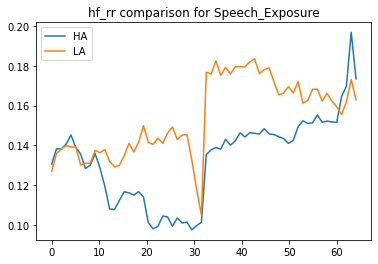

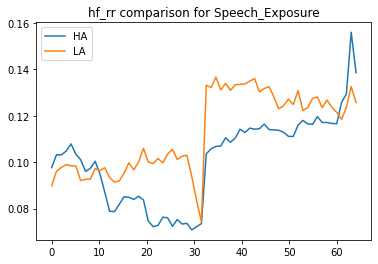

In [243]:
importlib.reload(dt)

metrics = [
    "hf_rr"
    # "bpm", "rmssd", "hf_rr", "lf_rr", "ibi", 
    # "mean_SCL", "SCR_rate"
]
phases = [
    # dr.Phases.BASE_REST, dr.Phases.BASE_SPEECH,

    # dr.Phases.BUG_RELAX,
    # dr.Phases.BUG_RELAX, dr.Phases.BUG_ANTICIPATE, dr.Phases.BUG_EXPOSURE, dr.Phases.BUG_BREAK, dr.Phases.BUG_REFLECT,
    # dr.Phases.BUG_RELAX, dr.Phases.BUG_ANTICIPATE,
    dr.Phases.BUG_EXPOSURE,
    # dr.Phases.BUG_BREAK, dr.Phases.BUG_REFLECT,
    # dr.Phases.BUG_RELAX, dr.Phases.BUG_ANTICIPATE, dr.Phases.BUG_EXPOSURE,
    # dr.Phases.BUG_EXPOSURE, dr.Phases.BUG_BREAK, dr.Phases.BUG_REFLECT,
    # dr.Phases.BUG_RELAX, dr.Phases.BUG_ANTICIPATE, dr.Phases.BUG_BREAK, dr.Phases.BUG_REFLECT,

    # dr.Phases.SPEECH_RELAX, 
    # dr.Phases.SPEECH_RELAX, dr.Phases.SPEECH_ANTICIPATE, dr.Phases.SPEECH_EXPOSURE, dr.Phases.SPEECH_BREAK, dr.Phases.SPEECH_REFLECT,
    # dr.Phases.SPEECH_RELAX, dr.Phases.SPEECH_ANTICIPATE,
    dr.Phases.SPEECH_EXPOSURE,
    # dr.Phases.SPEECH_BREAK, dr.Phases.SPEECH_REFLECT,
    # dr.Phases.SPEECH_RELAX, dr.Phases.SPEECH_ANTICIPATE, dr.Phases.SPEECH_EXPOSURE,
    # dr.Phases.SPEECH_EXPOSURE, dr.Phases.SPEECH_BREAK, dr.Phases.SPEECH_REFLECT
    # dr.Phases.SPEECH_RELAX, dr.Phases.SPEECH_ANTICIPATE, dr.Phases.SPEECH_BREAK, dr.Phases.SPEECH_REFLECT
]

plot_metrics(metrics, phases)

In [5]:
NUM_SUBJECTS = 52

def train_feature_fusion(clf, metrics, phases):
    """Combines features s.t. each feature vector represents each of the metrics for a single phase """
    metrics_folder = os.path.join(dr.Paths.DATA_DIR, "metrics")
    data_x = []
    data_y = []
    for phase in phases:
        ha_features = []
        la_features = []
        for metric in metrics:
            file = os.path.join(metrics_folder, f"{metric}_{phase}_ha.csv")
            arr = pd.read_csv(file, header=None, index_col=[0]).to_numpy()
            arr = arr[1:, 1:]
            col_mean = np.nanmean(arr, axis=1)
            idx = np.where(np.isnan(arr))
            arr[idx] = np.take(col_mean, idx[0])
            arr = np.nan_to_num(arr)
            # arr = normalize(arr)
            arr = np.mean(arr, axis=1)
            arr = np.reshape(arr, (arr.size, 1))
            ha_features.append(arr)

            file = os.path.join(metrics_folder, f"{metric}_{phase}_la.csv")
            arr = pd.read_csv(file, header=None, index_col=[0]).to_numpy()
            arr = arr[1:, 1:]
            col_mean = np.nanmean(arr, axis=1)
            idx = np.where(np.isnan(arr))
            arr[idx] = np.take(col_mean, idx[0])
            arr = np.nan_to_num(arr)
            # arr = normalize(arr)
            arr = np.mean(arr, axis=1)
            arr = np.reshape(arr, (arr.size, 1))
            la_features.append(arr)

        ha_features = np.hstack(ha_features)
        la_features = np.hstack(la_features)
        x = np.vstack([ha_features, la_features])
        y = np.asarray([1 for _ in range(ha_features.shape[0])] + [0 for _ in range(la_features.shape[0])])
        y = np.reshape(y, (y.size, 1))

        data_x.append(x)
        data_y.append(y)
        # print(f"x: {x.shape}")
        # print(f"y: {y.shape}")
    
    data_x = np.vstack(data_x)
    data_y = np.vstack(data_y)

    # print(f"data_x: {data_x.shape}")
    # print(f"data_y: {data_y.shape}")
    test_size = 0.1
    test_indices = random.sample(range(NUM_SUBJECTS), int(NUM_SUBJECTS*test_size))
    # print(test_indices)
    x_train = []
    y_train = []
    x_test = []
    y_test = []

    for i in range(y.size):
        if i%NUM_SUBJECTS in test_indices:
            x_test.append(x[i, :])
            y_test.append(y[i, :])
        else:
            x_train.append(x[i, :])
            y_train.append(y[i, :])
    
    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train).flatten()
    x_test = np.asarray(x_test)
    y_test = np.asarray(y_test).flatten()
    # print(f"x_train: {x_train.shape}")
    # print(f"y_train: {y_train.shape}")
    # print(f"x_test: {x_test.shape}")
    # print(f"y_test: {y_test.shape}")

    clf.fit(x_train, y_train)
    preds = clf.predict(x_test).flatten()
    # print(f"preds: {preds.shape}")
    actual = y_test

    # print(confusion_matrix(actual, preds))
    # print(classification_report(actual, preds))
    return accuracy_score(y_test, preds)